## All about datasets
#### Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.

#### To overcome the limitations related to noise in Twitter datasets, this News Headlines dataset for Sarcasm Detection is collected from two news website. TheOnion aims at producing sarcastic versions of current events and we collected all the headlines from News in Brief and News in Photos categories (which are sarcastic). We collect real (and non-sarcastic) news headlines from HuffPost.

#### This dataset consists of 28619 text headlines where each text belongs to two categories either sarcastic or not sarcastic

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sarcasm-headlines/Sarcasm_Headlines_Dataset_v2.json


## Loading the necessary libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
!pip install transformers
import torch
!pip install -q torch torchvision torchaudio
import transformers as tf
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from datasets import Dataset
from transformers import TrainingArguments
from transformers import Trainer
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

2025-12-30 04:48:04.977489: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767070084.998723     150 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767070085.005484     150 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

## Loading data

In [3]:

df = pd.read_json('/kaggle/input/sarcasm-headlines/Sarcasm_Headlines_Dataset_v2.json',lines = True)
df.head(6)

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
5,0,my white inheritance,https://www.huffingtonpost.com/entry/my-white-...


## Exploring data

In [4]:
df.shape

(28619, 3)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


### dataset not containing null values

In [6]:
df[df.is_sarcastic == 1]

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
7,1,richard branson's global-warming donation near...,https://www.theonion.com/richard-bransons-glob...
8,1,shadow government getting too large to meet in...,https://politics.theonion.com/shadow-governmen...
...,...,...,...
28612,1,polish rapper under fire for use of the word '...,https://entertainment.theonion.com/polish-rapp...
28614,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...
28615,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...
28617,1,mars probe destroyed by orbiting spielberg-gat...,https://www.theonion.com/mars-probe-destroyed-...


In [7]:
df[df.is_sarcastic == 0]

,is_sarcastic,headline,article_link
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
5,0,my white inheritance,https://www.huffingtonpost.com/entry/my-white-...
6,0,5 ways to file your taxes with less stress,https://www.huffingtonpost.com/entry/5-ways-to...
9,0,lots of parents know this scenario,https://www.huffingtonpost.comhttp://pubx.co/6...
...,...,...,...
28607,0,what our grieving family needs from loved ones...,https://www.huffingtonpost.com/entry/what-our-...
28608,0,stephen colbert attempts to list everything tr...,https://www.huffingtonpost.com/entry/stephen-c...
28609,0,bakery owner vows to stop making wedding cakes...,https://www.huffingtonpost.com/entry/jack-phil...
28613,0,how san antonio's dominant defense is fueling ...,https://www.huffingtonpost.com/entry/san-anton...


## Data visualization and preprocessing

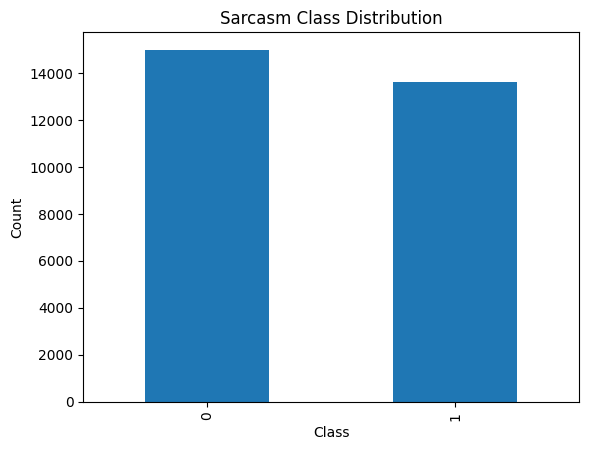

In [8]:
df['is_sarcastic'].value_counts().plot(kind='bar')
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Sarcasm Class Distribution")
plt.show()

In [9]:
df.isna().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

### dataset is nearby balanced

In [10]:
# removing this feature as it is of no use
df.drop(['article_link'], inplace = True,axis = 1)

In [11]:
df

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...
...,...,...
28614,1,jews to celebrate rosh hashasha or something
28615,1,internal affairs investigator disappointed con...
28616,0,the most beautiful acceptance speech this week...
28617,1,mars probe destroyed by orbiting spielberg-gat...


In [12]:
x = df.headline
y = df.is_sarcastic
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,stratify = y,random_state=0)

In [13]:
x_train.shape

(22895,)

In [14]:
x_test.shape

(5724,)

In [15]:
# Loading distilbert tokanizer and distilbert-base-uncased transformer model
# subword based tokenization

# pretrained_weights - "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [16]:
#Special tokens were added during tokenization to maintain consistency with the pretrained DistilBERT input format and to enable sentence-level representation.
train_tokenized = tokenizer(x_train.tolist(), truncation=True,
 add_special_tokens=True)
test_tokenized = tokenizer(x_test.tolist(), truncation=True,
 add_special_tokens=True)

In [17]:
train_tokenized[0]

Encoding(num_tokens=14, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [18]:
print(train_tokenized["input_ids"][0])
print(train_tokenized["input_ids"][1])
print(train_tokenized["attention_mask"][0])
print(train_tokenized["attention_mask"][1])

[101, 3189, 1024, 28516, 2015, 2085, 2191, 2039, 2570, 1003, 1997, 10474, 12706, 102]
[101, 5304, 4515, 2004, 2643, 17507, 2039, 2279, 2000, 15146, 20228, 9953, 7585, 102]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


###### Attention mask is a binary tensor that indicates which tokens should be attended to by the model and which correspond to padding.

In [19]:
data_collator = DataCollatorWithPadding(tokenizer)

In [20]:
batch = data_collator([
    {"input_ids": train_tokenized["input_ids"][0],
     "attention_mask": train_tokenized["attention_mask"][0]},
    {"input_ids": train_tokenized["input_ids"][1],
     "attention_mask": train_tokenized["attention_mask"][1]},
])

print(batch["input_ids"].shape)      # batch size(#of headlines) & padded sequence length 
print(batch["attention_mask"])


torch.Size([2, 14])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


## Model Building

In [21]:
id2label = {0: "Not Sarcasm", 1: "Sarcasm"}
label2id = {"Not Saecasm": 0, "Sarcasm": 1}

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", 
                                                           num_labels=2, 
                                                           id2label=id2label, 
                                                           label2id=label2id,)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:


train_dataset = Dataset.from_dict({
    "input_ids": train_tokenized["input_ids"],
    "attention_mask": train_tokenized["attention_mask"],
    "labels": y_train.tolist()
})

test_dataset = Dataset.from_dict({
    "input_ids": test_tokenized["input_ids"],
    "attention_mask": test_tokenized["attention_mask"],
    "labels": y_test.tolist()
})


In [23]:
# To convert into tensor
train_dataset.set_format("torch")
test_dataset.set_format("torch")

In [24]:
train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 22895
})

In [25]:


training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=100,
    save_strategy="epoch",
    report_to="none"
)

In [26]:

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}


In [27]:


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


In [28]:
trainer.train()


Step,Training Loss
100,0.574900
200,0.404100
300,0.385200
400,0.343700
500,0.350700
600,0.325300
700,0.320700
800,0.316000
900,0.342900
1000,0.355600


TrainOutput(global_step=8586, training_loss=0.15971153453877554, metrics={'train_runtime': 240.7682, 'train_samples_per_second': 285.274, 'train_steps_per_second': 35.661, 'total_flos': 380748560193216.0, 'train_loss': 0.15971153453877554, 'epoch': 3.0})

In [29]:
trainer.evaluate()


{'eval_loss': 0.42762643098831177,
 'eval_accuracy': 0.9294199860237596,
 'eval_runtime': 5.1709,
 'eval_samples_per_second': 1106.961,
 'eval_steps_per_second': 138.467,
 'epoch': 3.0}

## Model evaluation

In [30]:
predictions = trainer.predict(test_dataset)

logits = predictions.predictions
y_pred = logits.argmax(axis=1)
y_true = predictions.label_ids
print(y_true,y_pred)

[0 0 1 ... 0 1 1] [0 0 1 ... 0 1 1]


In [31]:


print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2997
           1       0.93      0.92      0.93      2727

    accuracy                           0.93      5724
   macro avg       0.93      0.93      0.93      5724
weighted avg       0.93      0.93      0.93      5724



In [32]:
save_path = "/kaggle/working/distilbert_sarcasm_model"

trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

('/kaggle/working/distilbert_sarcasm_model/tokenizer_config.json',
 '/kaggle/working/distilbert_sarcasm_model/special_tokens_map.json',
 '/kaggle/working/distilbert_sarcasm_model/vocab.txt',
 '/kaggle/working/distilbert_sarcasm_model/added_tokens.json',
 '/kaggle/working/distilbert_sarcasm_model/tokenizer.json')